# TEST 0

In [1]:
from __future__ import absolute_import, division, print_function

%load_ext autoreload
%reload_ext autoreload
%autoreload 2

In [2]:
from config import *
from common import *
display.clear_output()

In [3]:
from affwild2_challenge.basic_emotion_v1.dataset_affwild2 import AffWild2Dataset, emotiw_affwild2_mapping, affwild2_name, affwild2_emotiw_mapping, emotiw_name
from affwild2_challenge.basic_emotion_v1.dataload_expr_va_frames import VAFramesExprImageBalancedDataLoader
from affwild2_challenge.basic_emotion_v1.datagen_expr_va_frames  import DataGenerator

from affwild2_challenge.basic_emotion_v1.models.models_expr_frames import EXP_VA_FRAMES_V0

from affwild2_challenge.basic_emotion_v1.dataaug  import train_aug, valid_aug
from affwild2_challenge.basic_emotion_v1.dataaug  import vggface2_preprocessing_input, vggface2_postprocessing_input

from affwild2_challenge.basic_emotion_v1.losses import ccc, loss_ccc, ccc_numpy
from affwild2_challenge.basic_emotion_v1.metrics import expr_score, f1_score, concordance_cc2

## 1. Setup Environments

In [4]:
params = {}
params["results_dir"] = os.path.join(sub_dir, "results", "t31")

params["db_file"] = os.path.join(dataset_dir, "AffWild2/data/affwild2_cropped_frames_v1.h5")
params["db_root"] = os.path.join(dataset_dir, "AffWild2/data/cropped")

params["batch_size"] = 16
params["gpus"] = ["0"]
# params["gpus"] = ["1", "2", "3"]
# params["gpus"] = ["-1"]
params["weights_path"] = os.path.join(sub_dir, "weights", "t31_affwild2_expr_va_frames_weights_200224012214_epoch-58_loss-1.70_class-0.82_0.80_0.54_reg-0.00_-0.00_0.03.h5")
params["model_base_path"] = os.path.join(sub_dir, "weights", "rafdb_affectnetweight_vggface2_resnes50_ft_01_weights_190513200935_epoch-28_val_loss-0.70_val_acc-0.87.h5")

params["debug"] = False
params["run_train"] = False
params["run_valid"] = False
params["run_test"] = True
params["run_test_va"] = True

params["val_train"] = False
params["val_valid"] = True

params["n_blocks"]  = 16
params["use_parallel_model"] = True
params["max_queue_size"] = 22
params["workers"] = 16
params["use_multiprocessing"] = False


print("parameters: ")
for key in params.keys(): print("+ %s: %s"%(key,params[key]))

if os.path.exists(params["results_dir"]) == False: os.makedirs(params["results_dir"])

parameters: 
+ results_dir: /mnt/ubuntu1/dntai/projects/Emotion/AffWild2Prj/submit1/results/t31
+ db_file: /mnt/ubuntu1/dntai/projects/Emotion/AffWild2Prj/data/datasets/AffWild2/data/affwild2_cropped_frames_v1.h5
+ db_root: /mnt/ubuntu1/dntai/projects/Emotion/AffWild2Prj/data/datasets/AffWild2/data/cropped
+ batch_size: 128
+ gpus: ['-1']
+ weights_path: /mnt/ubuntu1/dntai/projects/Emotion/AffWild2Prj/submit1/weights/t31_affwild2_expr_va_frames_weights_200224012214_epoch-58_loss-1.70_class-0.82_0.80_0.54_reg-0.00_-0.00_0.03.h5
+ model_base_path: /mnt/ubuntu1/dntai/projects/Emotion/AffWild2Prj/submit1/weights/rafdb_affectnetweight_vggface2_resnes50_ft_01_weights_190513200935_epoch-28_val_loss-0.70_val_acc-0.87.h5
+ debug: False
+ run_train: False
+ run_valid: False
+ run_test: True
+ run_test_va: True
+ val_train: False
+ val_valid: True
+ n_blocks: 16
+ use_parallel_model: True
+ max_queue_size: 22
+ workers: 16
+ use_multiprocessing: False


In [5]:
# Choose gpus, init session
choose_keras_environment(gpus = params["gpus"], keras_backend = "tensorflow", verbose = 1)
init_session()
check_tensorflow_environment()

Environment GPUs:
+ Choose GPUs:  -1
+ Keras backend:  tensorflow


Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device

TensorFlow Version: 1.15.0
No GPU found. Please use a GPU to train your neural network.


## 2. Setup Data

In [6]:
# Dataset Configuration
dataset_info  = dict(db_file = params["db_file"], db_root = params["db_root"])
print("dataset_info: ")
for key in dataset_info.keys(): print("+ %s: %s"%(key,dataset_info[key]))
    
ds = AffWild2Dataset(**dataset_info)
ds.load_scheme_emotion_va()

dataset_info: 
+ db_file: /mnt/ubuntu1/dntai/projects/Emotion/AffWild2Prj/data/datasets/AffWild2/data/affwild2_cropped_frames_v1.h5
+ db_root: /mnt/ubuntu1/dntai/projects/Emotion/AffWild2Prj/data/datasets/AffWild2/data/cropped
Loading Scheme Emotion VA: 
 + Loading train: 194
 + Loading valid: 57
 + Loading test: 223
 + Loading va_test: 139


Number of images:	721631
Distribution:  {'Neutral': 451062, 'Angry': 18470, 'Disgust': 7095, 'Fear': 9864, 'Happy': 116562, 'Sad': 85803, 'Surprise': 32775}


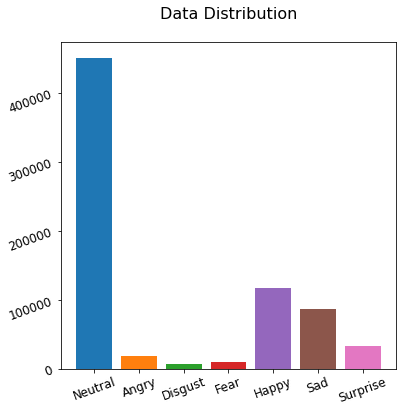

Number of images:	255683
Distribution:  {'Neutral': 156069, 'Angry': 6803, 'Disgust': 977, 'Fear': 8152, 'Happy': 36605, 'Sad': 31186, 'Surprise': 15891}


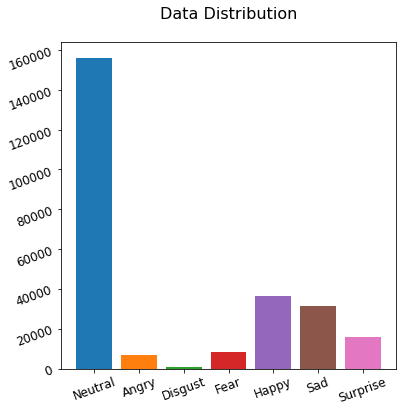

Number of images:	997326
Distribution:  {'Test': 997326}


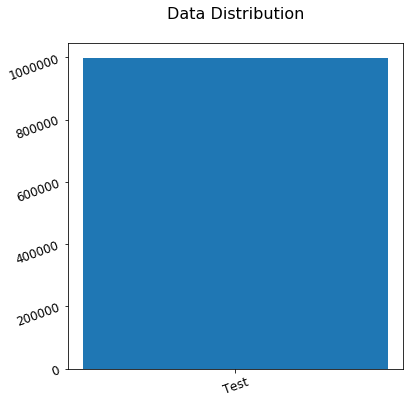

In [7]:
ds.view_emotion_summary(ds.a_idx_train, figsize=(6,6))
ds.view_emotion_summary(ds.a_idx_valid, figsize=(6,6))
ds.view_emotion_summary(ds.a_idx_test, figsize=(6,6));

Number of images:	721631
--------------------
Process va_valence: 
[0.148 0.148 0.148 ... 0.89  0.874 0.874]
Invalid distribution: Empty


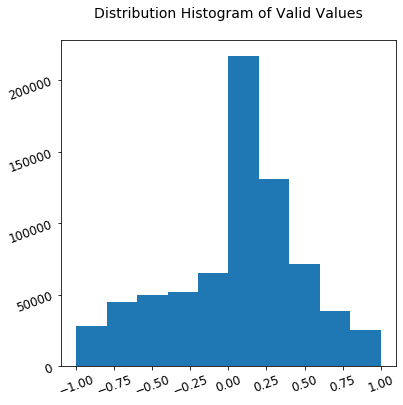

--------------------
Process va_arousal: 
[0.352 0.36  0.362 ... 0.874 0.874 0.874]
Invalid distribution: Empty


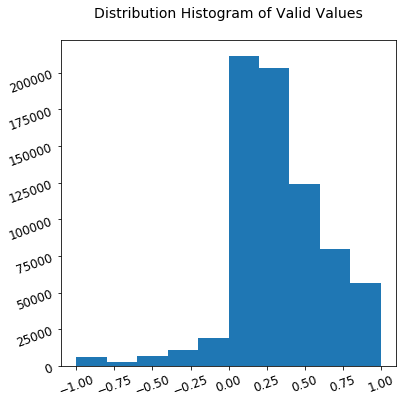

Number of images:	255683
--------------------
Process va_valence: 
[-1.    -1.    -1.    ... -0.942 -0.942 -0.942]
Invalid distribution: Empty


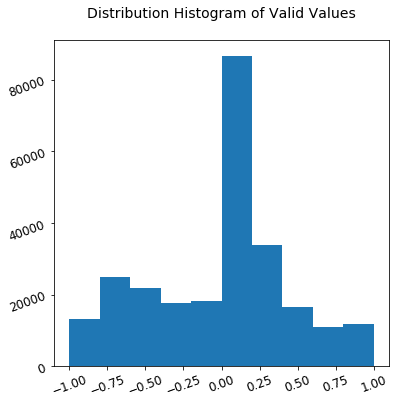

--------------------
Process va_arousal: 
[0.748 0.748 0.748 ... 0.705 0.683 0.689]
Invalid distribution: Empty


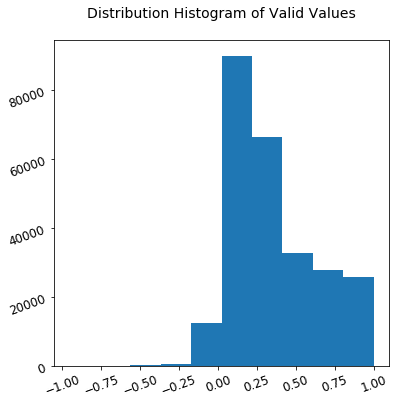

Number of images:	716665
--------------------
Process va_valence: 
[-2. -2. -2. ... -2. -2. -2.]
Invalid distribution:  {'Test': 716665}
Valid distribution: Empty
--------------------
Process va_arousal: 
[-2. -2. -2. ... -2. -2. -2.]
Invalid distribution:  {'Test': 716665}
Valid distribution: Empty


In [8]:
ds.view_va_summary(ds.a_idx_train, figsize=(6,6))
ds.view_va_summary(ds.a_idx_valid, figsize=(6,6))
ds.view_va_summary(ds.a_idx_va_test, figsize=(6,6))

In [9]:
train_loader = VAFramesExprImageBalancedDataLoader(ds.a_idx_train, ds.a_scheme_train, ds, 
                                    n_classes = 7,
                                    n_blocks = params["n_blocks"],
                                    transforms= valid_aug(224),
                                    mode = "valid", 
                                    has_balance=False, 
                                    balanced_mode = "", 
                                    capacity = 0,  
                                    preprocessing_image_fn = None)

valid_loader = VAFramesExprImageBalancedDataLoader(ds.a_idx_valid, ds.a_scheme_valid, ds, 
                                    n_classes = 7,
                                    n_blocks = params["n_blocks"],
                                    transforms= valid_aug(224),
                                    mode = "valid", 
                                    has_balance=False, 
                                    balanced_mode = "", 
                                    capacity = 0,  
                                    preprocessing_image_fn = None)

test_loader = VAFramesExprImageBalancedDataLoader(ds.a_idx_test, ds.a_scheme_test, ds, 
                                    n_classes = 7,
                                    n_blocks = params["n_blocks"],
                                    transforms= valid_aug(224),
                                    mode = "test", 
                                    has_balance=False, 
                                    balanced_mode = "", 
                                    capacity = 0,  
                                    preprocessing_image_fn = None)

test_va_loader = VAFramesExprImageBalancedDataLoader(ds.a_idx_va_test, ds.a_scheme_va_test, ds, 
                                    n_classes = 7,
                                    n_blocks = params["n_blocks"],
                                    transforms= valid_aug(224),
                                    mode = "test", 
                                    has_balance=False, 
                                    balanced_mode = "", 
                                    capacity = 0,  
                                    preprocessing_image_fn = None)

(224, 224, 3) (16, 224, 224, 3) (7,) 0.37 0.203
(224, 224, 3) (16, 224, 224, 3) (7,) 0.748 -0.879
(224, 224, 3) (16, 224, 224, 3) [None, 0.128, 0.0]
(224, 224, 3) (16, 224, 224, 3) [None, -2.0, -2.0]
Training
View 3D Images: Emotion = Happy - 0.37 - 0.203


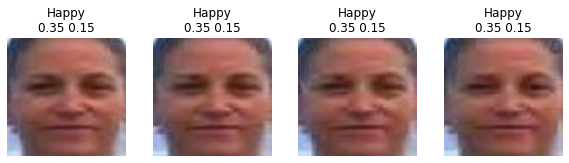

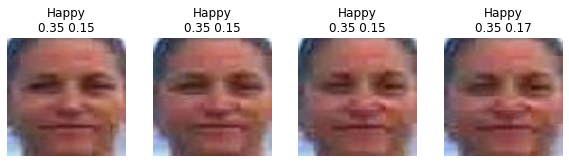

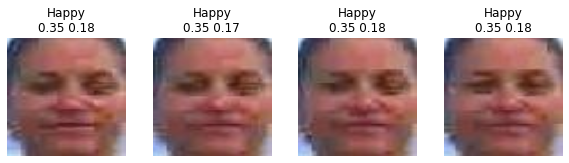

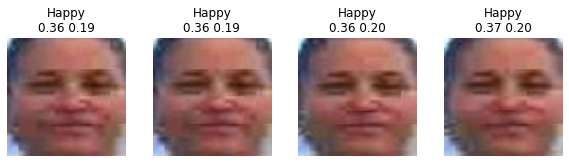

Validating
View 3D Images: Emotion = Neutral - 0.748 - -0.879


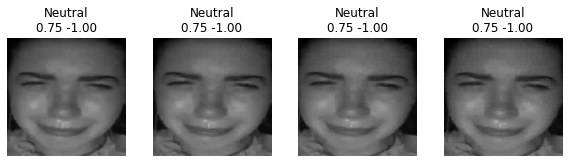

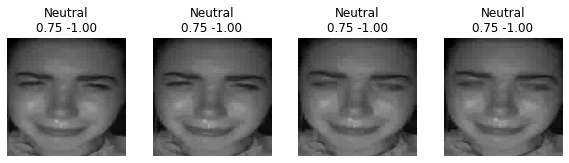

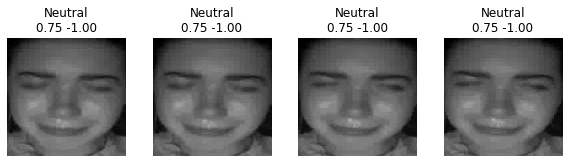

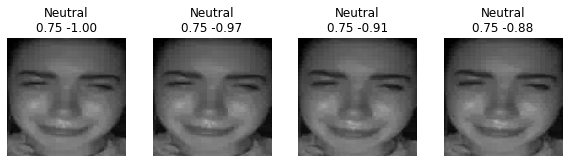

Testing
View 3D Images: Emotion = Unknown - 0.128 - 0.0


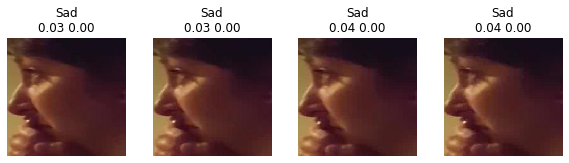

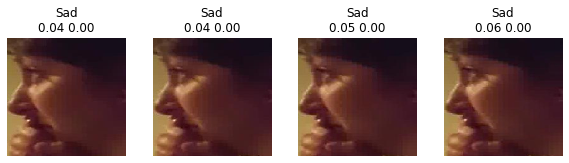

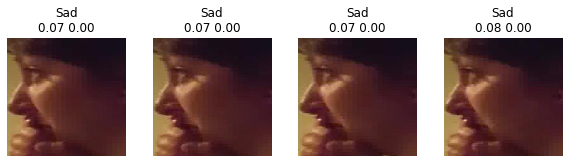

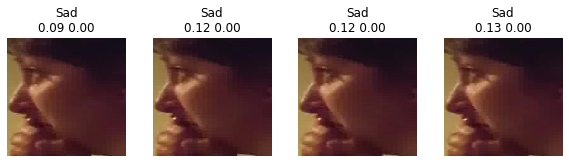

Testing VA
View 3D Images: Emotion = Unknown - -2.0 - -2.0


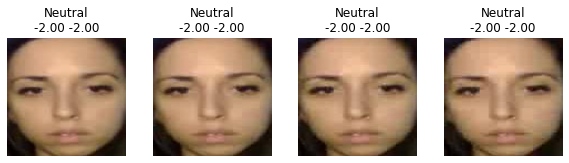

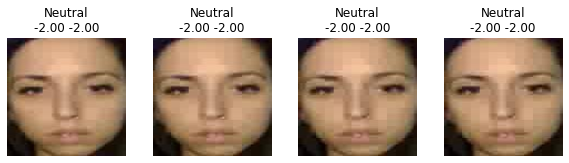

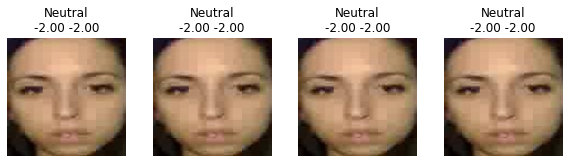

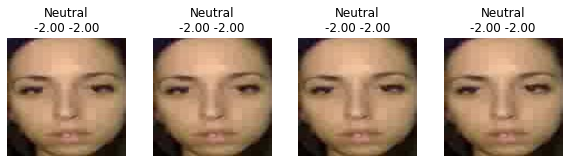

In [10]:
x, y = train_loader[20]
print(x[0].shape, x[1].shape, y[0].shape, y[1], y[2])
x, y = valid_loader[20]
print(x[0].shape, x[1].shape, y[0].shape, y[1], y[2])
x, y = test_loader[20]
print(x[0].shape, x[1].shape, y)
x, y = test_va_loader[20]
print(x[0].shape, x[1].shape, y)

print("Training")
train_loader.view_image(20, cols = 4)
print("Validating")
valid_loader.view_image(20, cols = 4)
print("Testing")
test_loader.view_image(20, cols = 4)
print("Testing VA")
test_va_loader.view_image(20, cols = 4)

In [11]:
train_gen = DataGenerator(dataloader = train_loader, 
                          has_dynamic_blocks = False,
                          dynamic_blocks = [4, 8, 16, 32],
                          preprocessing_image_fn = vggface2_preprocessing_input,
                          batch_size = params["batch_size"], 
                          shuffle = False, seed = None )
print("Train: ")
x, y = next(train_gen)
print(x[0].shape, np.min(x[0]), np.max(x[0]))
print(x[1].shape, np.min(x[1]), np.max(x[1]))
print(y[0].shape, y[1].shape, y[2].shape)

valid_gen = DataGenerator(dataloader = valid_loader, 
                          has_dynamic_blocks = False,
                          dynamic_blocks = [4, 8, 16, 32],
                          preprocessing_image_fn = vggface2_preprocessing_input,
                          batch_size = params["batch_size"], 
                          shuffle = False, seed = None )
print("Valid: ")
x, y = next(valid_gen)
print(x[0].shape, np.min(x[0]), np.max(x[0]))
print(x[1].shape, np.min(x[1]), np.max(x[1]))
print(y[0].shape, y[1].shape, y[2].shape)

test_gen = DataGenerator(dataloader = test_loader, 
                         has_dynamic_blocks = False,
                         dynamic_blocks = [4, 8, 16, 32],
                         preprocessing_image_fn = vggface2_preprocessing_input,
                         batch_size = params["batch_size"], 
                         shuffle = False, seed = None )
print("Test: ")
x, y = next(test_gen)
print(x[0].shape, x[1].shape, y)

test_va_gen = DataGenerator(dataloader = test_va_loader, 
                         has_dynamic_blocks = False,
                         dynamic_blocks = [4, 8, 16, 32],
                         preprocessing_image_fn = vggface2_preprocessing_input,
                         batch_size = params["batch_size"], 
                         shuffle = False, seed = None )
print("Test VA: ")
x, y = next(test_va_gen)
print(x[0].shape, x[1].shape, y)

Train: 
(32, 224, 224, 3) -114.0912 163.5047
(32, 16, 224, 224, 3) -114.0912 163.5047
(32, 7) (32, 1) (32, 1)
Valid: 
(32, 224, 224, 3) -131.0912 92.5047
(32, 16, 224, 224, 3) -131.0912 92.5047
(32, 7) (32, 1) (32, 1)
Test: 
(32, 224, 224, 3) (32, 16, 224, 224, 3) None
Test VA: 
(32, 224, 224, 3) (32, 16, 224, 224, 3) None


## 3. Setup Model

In [12]:
if params["run_train"]==True or params["run_valid"]==True or params["run_test"]==True or params["run_test_va"] == True:
    # Load model VGGFace
    K.clear_session()
    model_base = load_model(params["model_base_path"])
    
    # Summary
    model_base.summary()
    
    # Free_weights for fine-tuning
    idx_predictions = -1
    idx_features = -1
    idx_conv = -1

    layer_predictions_name = "predictions"
    layer_conv_name = "conv4_1_1x1_reduce"
    layer_feature_name = "features"

    for idx in range(len(model_base.layers)):
        if model_base.layers[idx].name == layer_feature_name: # features, 
            idx_features = idx
        elif model_base.layers[idx].name == layer_conv_name: # conv4_1_1x1_reduce
            idx_conv = idx
        elif model_base.layers[idx].name == layer_predictions_name: # conv4_1_1x1_reduce
            idx_predictions = idx

    for idx in range(len(model_base.layers)):
        if idx<idx_conv:
            model_base.layers[idx].trainable = False
        else:
            model_base.layers[idx].trainable = True
    # for

    print(idx_features)
    print(idx_conv)
    print(idx_predictions)

    model_base_fea = Model(inputs = model_base.input, 
                        outputs = model_base.layers[idx_features].output)
    model_base_pre = Model(inputs = model_base.input, 
                        outputs = model_base.layers[idx_predictions].output)
    
    # Load model
    model_config = dict(
        model_base_fea = model_base_fea, 
        model_base_pre = model_base_pre, 
        nb_classes = 7,
        fc_regre_finals = [1024, 1024], 
        fc_regre_dropout = [0.1, 0.1, 0.1],
        fc_class_finals = [1024, 0], 
        fc_class_dropout = [0.1, 0.1, 0.1]
    )
    model = EXP_VA_FRAMES_V0(**model_config)
    
    # Load Weights
    print(params["weights_path"])
    model.load_weights(params["weights_path"])
    
    # Model Summary
    model.summary()
    
    if params["use_parallel_model"] == True and len(params["gpus"])>=2:
        model = multi_gpu_model(model, gpus = len(params["gpus"]))
    # if
# if    

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
base_input (InputLayer)         (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        base_input[0][0]                 
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
________

## 4. Predict

### 4.1. Train

In [13]:
if params["run_train"] == True:
    train_gen.reset()

    if params["debug"] == True:
        steps = 50
        y_pred = model.predict(train_gen, steps = steps,
                               verbose = 1,
                               max_queue_size=params["max_queue_size"], 
                               workers=params["workers"], 
                               use_multiprocessing=params["use_multiprocessing"])
    else:
        y_pred = model.predict(train_gen, 
                               verbose = 1,
                               max_queue_size=params["max_queue_size"], 
                               workers=params["workers"], 
                               use_multiprocessing=params["use_multiprocessing"])
    # if
# if

In [14]:
if params["run_train"] == True:
    y_results = {}
    y_results["emotion"]    = y_pred[0]
    y_results["aro_ccc"]    = y_pred[1]
    y_results["val_ccc"]    = y_pred[2]
    y_results["valaro_mse"] = y_pred[3]

    save_path = os.path.join(params["results_dir"], f"train_{params['n_blocks']}.npz")
    print(f"Save Train: {save_path}")
    np.savez(save_path, **y_results)
# if

### 4.2. Valid

In [ ]:
if params["run_valid"] == True:
    valid_gen.reset()

    if params["debug"] == True:
        steps = 50
        y_pred = model.predict(valid_gen, steps = steps, 
                               verbose = 1,
                               max_queue_size=params["max_queue_size"], 
                               workers=params["workers"], 
                               use_multiprocessing=params["use_multiprocessing"])
    else:
        y_pred = model.predict(valid_gen,                                
                               verbose = 1,
                               max_queue_size=params["max_queue_size"], 
                               workers=params["workers"], 
                               use_multiprocessing=params["use_multiprocessing"])
    # if
# if

   2/7991 [..............................] - ETA: 86:19:37

In [ ]:
if params["run_valid"] == True:
    y_results = {}
    y_results["emotion"]    = y_pred[0]
    y_results["aro_ccc"]    = y_pred[1]
    y_results["val_ccc"]    = y_pred[2]
    y_results["valaro_mse"] = y_pred[3]

    save_path = os.path.join(params["results_dir"], f"valid_{params['n_blocks']}.npz")
    print(f"Save Valid: {save_path}")
    np.savez(save_path, **y_results)
# if

### 4.3. Test

In [ ]:
if params["run_test"] == True:    
    test_gen.reset()

    if params["debug"] == True:
        steps = 50
        y_pred = model.predict(test_gen, steps = steps,
                               verbose = 1,
                               max_queue_size=params["max_queue_size"], 
                               workers=params["workers"], 
                               use_multiprocessing=params["use_multiprocessing"])
    else:
        y_pred = model.predict(test_gen,                                
                               verbose = 1,
                               max_queue_size=params["max_queue_size"], 
                               workers=params["workers"], 
                               use_multiprocessing=params["use_multiprocessing"])
# if

In [ ]:
if params["run_test"] == True:    
    y_results = {}
    y_results["emotion"]    = y_pred[0]
    y_results["aro_ccc"]    = y_pred[1]
    y_results["val_ccc"]    = y_pred[2]
    y_results["valaro_mse"] = y_pred[3]

    save_path = os.path.join(params["results_dir"], f"test_{params['n_blocks']}.npz")
    print(f"Save Test: {save_path}")
    np.savez(save_path, **y_results)
# if

### 4.4. Test VA

In [ ]:
if params["run_test_va"] == True:    
    test_va_gen.reset()

    if params["debug"] == True:
        steps = 50
        y_pred = model.predict(test_va_gen, steps = steps,
                               verbose = 1,
                               max_queue_size=params["max_queue_size"], 
                               workers=params["workers"], 
                               use_multiprocessing=params["use_multiprocessing"])                               
    else:
        y_pred = model.predict(test_va_gen, 
                               verbose = 1,
                               max_queue_size=params["max_queue_size"], 
                               workers=params["workers"], 
                               use_multiprocessing=params["use_multiprocessing"])                                    
# if

In [ ]:
if params["run_test_va"] == True:    
    y_results = {}
    y_results["emotion"]    = y_pred[0]
    y_results["aro_ccc"]    = y_pred[1]
    y_results["val_ccc"]    = y_pred[2]
    y_results["valaro_mse"] = y_pred[3]

    save_path = os.path.join(params["results_dir"], f"test_va_{params['n_blocks']}.npz")
    print(f"Save Test: {save_path}")
    np.savez(save_path, **y_results)
# if

## 5. Evaluation

### 5.1. Train

In [ ]:
if params["val_train"] == True:   
    
    load_path  = os.path.join(params["results_dir"], f"train_{params['n_blocks']}.npz")
    a_idx_data = ds.a_idx_train

    y_results = dict(np.load(load_path, allow_pickle=True))
    
    y_pred_emotion_label = emotiw_affwild2_mapping[np.argmax(y_results["emotion"], axis = 1)]
    y_true_emotion_label = ds.df_frames.loc[a_idx_data]["expr_emotion"].values
    
    a_summary_report = model_report(y_true_emotion_label, y_pred_emotion_label, affwild2_name)
    s_summary_report = buffer_print_string(print_summary, a_summary_report)
    print(s_summary_report)
    
    f1   = a_summary_report["model_f1_avg_weighted"]
    acc  = a_summary_report["model_acc_all"]
    expr = f1 * 0.66 + acc * 0.33
    print(f"f1: {f1}")
    print(f"acc: {acc}")
    print(f"expr: {expr}")
    
    plt.figure(figsize=(6,6))
    plot_confusion_matrix(y_true_emotion_label, y_pred_emotion_label, 
                          title='Average accuracy \n ( Accuracy={acc:.2f} )\n',
                          classes = affwild2_name)
    
    aro_pred = y_results["aro_ccc"].flatten()
    val_pred = y_results["val_ccc"].flatten()
    aro_true = ds.df_frames.loc[a_idx_data]["va_arousal"].values
    val_true = ds.df_frames.loc[a_idx_data]["va_valence"].values

    aro_ccc1 = concordance_cc2(aro_true, aro_pred)
    aro_ccc2 = ccc_numpy(aro_true, aro_pred)
    val_ccc1 = concordance_cc2(val_true, val_pred)
    val_ccc2 = ccc_numpy(val_true, val_pred)

    avg_ccc1 = (aro_ccc1 + val_ccc1) / 2.0
    avg_ccc2 = (aro_ccc2 + val_ccc2) / 2.0

    print(f"aro: {aro_ccc1}, {aro_ccc2}")
    print(f"val: {val_ccc1}, {val_ccc2}")
    print(f"valaro_avg: {avg_ccc1}, {avg_ccc2}")
# if

## 5.2. Valid

Classification Report: 
               precision    recall  f1-score   support

     Neutral       0.83      0.42      0.56    156069
       Angry       0.13      0.31      0.19      6803
     Disgust       0.05      0.25      0.08       977
        Fear       0.07      0.05      0.06      8152
       Happy       0.46      0.69      0.55     36605
         Sad       0.43      0.59      0.50     31186
    Surprise       0.20      0.63      0.31     15891

    accuracy                           0.48    255683
   macro avg       0.31      0.42      0.32    255683
weighted avg       0.64      0.48      0.51    255683

Confustion Matrix Int: 
 [[65952 11013  2984  4616 25735 14656 31113]
 [  691  2114    37   164   599  2515   683]
 [  129   145   243    11   132   145   172]
 [ 1371   195   449   418   230  3717  1772]
 [ 3367   540   115   135 25381  2771  4296]
 [ 6166   791  1318   829  1856 18260  1966]
 [ 2107  1159   153   175  1713   497 10087]]

Confustion Matrix Norm: 
 [[42.26  7

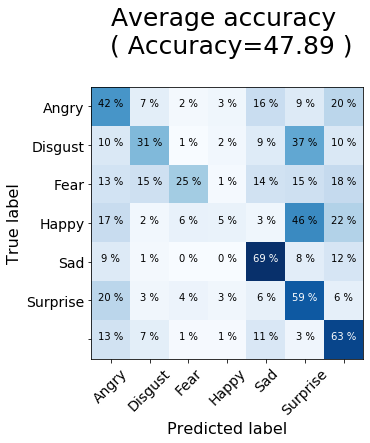

In [7]:
if params["val_valid"] == True:   
    
    load_path  = os.path.join(params["results_dir"], f"valid_{params['n_blocks']}.npz")
    a_idx_data = ds.a_idx_valid

    y_results = dict(np.load(load_path, allow_pickle=True))
    
    y_pred_emotion_label = emotiw_affwild2_mapping[np.argmax(y_results["emotion"], axis = 1)]
    y_true_emotion_label = ds.df_frames.loc[a_idx_data]["expr_emotion"].values
    
    a_summary_report = model_report(y_true_emotion_label, y_pred_emotion_label, affwild2_name)
    s_summary_report = buffer_print_string(print_summary, a_summary_report)
    print(s_summary_report)
    
    f1   = a_summary_report["model_f1_avg_weighted"]
    acc  = a_summary_report["model_acc_all"]
    expr = f1 * 0.66 + acc * 0.33
    print(f"f1: {f1}")
    print(f"acc: {acc}")
    print(f"expr: {expr}")
    
    plt.figure(figsize=(6,6))
    plot_confusion_matrix(y_true_emotion_label, y_pred_emotion_label, 
                          title='Average accuracy \n ( Accuracy={acc:.2f} )\n',
                          classes = affwild2_name)
    
    aro_pred = y_results["aro_ccc"].flatten()
    val_pred = y_results["val_ccc"].flatten()
    aro_true = ds.df_frames.loc[a_idx_data]["va_arousal"].values
    val_true = ds.df_frames.loc[a_idx_data]["va_valence"].values

    aro_ccc1 = concordance_cc2(aro_true, aro_pred)
    aro_ccc2 = ccc_numpy(aro_true, aro_pred)
    val_ccc1 = concordance_cc2(val_true, val_pred)
    val_ccc2 = ccc_numpy(val_true, val_pred)

    avg_ccc1 = (aro_ccc1 + val_ccc1) / 2.0
    avg_ccc2 = (aro_ccc2 + val_ccc2) / 2.0

    print(f"aro: {aro_ccc1}, {aro_ccc2}")
    print(f"val: {val_ccc1}, {val_ccc2}")
    print(f"valaro_avg: {avg_ccc1}, {avg_ccc2}")
# if